In [169]:
# Import important libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn import svm
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

In [170]:
# Read csv as a dataframe
df = pd.read_csv("/content/Skydata_pro.csv")

## Data exploratory analysis.

In [171]:
# Information regarding the database
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      104529 non-null  float64
 1   ra         104497 non-null  float64
 2   dec        104486 non-null  float64
 3   u          104547 non-null  float64
 4   g          104502 non-null  float64
 5   r          104464 non-null  float64
 6   i          104494 non-null  float64
 7   z          104482 non-null  float64
 8   run        104492 non-null  float64
 9   rerun      104461 non-null  float64
 10  camcol     104504 non-null  float64
 11  field      104524 non-null  float64
 12  specobjid  104502 non-null  float64
 13  class      105000 non-null  object 
 14  redshift   104483 non-null  float64
 15  plate      104490 non-null  float64
 16  mjd        104497 non-null  float64
 17  fiberid    104483 non-null  float64
dtypes: float64(17), object(1)
memory usage: 14.4+ MB


In [172]:
# Converting string labels such as (Galaxy,star,etc) to integer(0,1,2...) 
labels = df["class"].to_numpy()
labEncoder = LabelEncoder()
labels = labEncoder.fit_transform(labels)

## Probability Distribution of Astronomical Entity

In [173]:
fig = px.pie(df, names='class', title='Class distribution', hole=0.4)
fig.show()

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.

People commonly use correlation matrixes as inputs for exploratory factor analysis, confirmatory factor analysis, structural equation models, and linear regression when excluding missing values pairwise.

In [174]:
correlation_matrix = df.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning:

All-NaN slice encountered



,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
objid,1.000000,-0.065889,-0.057190,0.013020,0.022648,0.024712,0.028093,0.030533,1.000000,nan,0.001437,-0.164326,0.370312,0.030812,0.369886,0.417729,0.097579
ra,-0.065889,1.000000,0.077856,0.020049,0.015029,0.010591,0.004495,-0.000656,-0.065117,nan,-0.007097,0.021702,-0.059785,-0.008728,-0.059208,-0.034230,-0.028453
dec,-0.057190,0.077856,1.000000,-0.027421,-0.012609,-0.003834,-0.000389,0.005583,-0.057191,nan,0.080744,-0.113240,0.016344,0.010038,0.016306,0.025325,0.029160
u,0.013020,0.020049,-0.027421,1.000000,0.837211,0.689442,0.614821,0.563017,0.012983,nan,0.006062,0.011358,0.016117,0.182135,0.016425,-0.004335,0.020029
g,0.022648,0.015029,-0.012609,0.837211,1.000000,0.958569,0.918854,0.891803,0.022710,nan,0.011079,0.006531,0.158492,0.448740,0.158656,0.123964,0.073203
r,0.024712,0.010591,-0.003834,0.689442,0.958569,1.000000,0.977188,0.963358,0.024659,nan,0.012687,0.001503,0.211993,0.483583,0.212320,0.178446,0.090489
i,0.028093,0.004495,-0.000389,0.614821,0.918854,0.977188,1.000000,0.978324,0.027961,nan,0.014825,-0.002196,0.243099,0.480910,0.243282,0.212473,0.097266
z,0.030533,-0.000656,0.005583,0.563017,0.891803,0.963358,0.978324,1.000000,0.030606,nan,0.013237,-0.004628,0.257392,0.472555,0.257905,0.230505,0.101270
run,1.000000,-0.065117,-0.057191,0.012983,0.022710,0.024659,0.027961,0.030606,1.000000,nan,0.001194,-0.163845,0.370718,0.031382,0.370071,0.417970,0.097089
rerun,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


- The variables objid, run, rerun, field, fiberid have been removed from the dataset as they are observation instrumentation identification codes. The variable camcol was also removed as it identifies the row of survey instruments from which the observation was taken and has no relevance to the analysis of the light spectra.

- The variables described above also have a very low correlation with those identifying the photometric filters, which are necessary for classification of the celestial body.

- The variable plate and mjd, despite having a medium correlation with those identifying photometric filters, were removed because they provide information regarding the date of detection and the spectrograph used, which are not relevant to the classification of spectra light.

In [175]:
#  Drop columns 
df= df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'camcol', 'specobjid','plate', 'mjd','fiberid','class' ] ,axis=1 )

In [176]:
correlation_matrix = df.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,ra,dec,u,g,r,i,z,redshift
ra,1.000000,0.077856,0.020049,0.015029,0.010591,0.004495,-0.000656,-0.008728
dec,0.077856,1.000000,-0.027421,-0.012609,-0.003834,-0.000389,0.005583,0.010038
u,0.020049,-0.027421,1.000000,0.837211,0.689442,0.614821,0.563017,0.182135
g,0.015029,-0.012609,0.837211,1.000000,0.958569,0.918854,0.891803,0.448740
r,0.010591,-0.003834,0.689442,0.958569,1.000000,0.977188,0.963358,0.483583
i,0.004495,-0.000389,0.614821,0.918854,0.977188,1.000000,0.978324,0.480910
z,-0.000656,0.005583,0.563017,0.891803,0.963358,0.978324,1.000000,0.472555
redshift,-0.008728,0.010038,0.182135,0.448740,0.483583,0.480910,0.472555,1.000000


In [177]:
# Determine the Null values
df.isnull().sum()

ra          503
dec         514
u           453
g           498
r           536
i           506
z           518
redshift    517
dtype: int64

In [178]:
df.describe()

,ra,dec,u,g,r,i,z,redshift
count,104497.000000,104486.000000,104547.000000,104502.000000,104464.000000,104494.000000,104482.000000,104483.000000
mean,177.363628,25.077019,18.646125,17.446461,16.933422,16.682464,16.527226,0.202460
std,78.323752,20.549558,0.828695,1.003252,1.158455,1.236730,1.308751,0.484099
min,0.013061,-19.495456,10.611810,9.668339,9.005167,8.848403,8.947795,-0.004136
25%,136.207329,6.796899,18.226545,16.876755,16.220455,15.889685,15.648400,0.000007
50%,180.315466,23.976166,18.881530,17.543095,16.934460,16.646070,16.479285,0.048396
75%,224.385600,40.356285,19.278400,18.099840,17.648455,17.416190,17.320373,0.101922
max,359.999615,84.490494,19.599950,19.996050,31.990100,32.141470,29.383740,7.011245


In [179]:
# FillNA values with the 0 
df = df.fillna(0)

Outlier Detction

In [180]:
def remove_outlier(df):
  """
  This function removes outliers using unsupervised approach (LocalOutlierFactor) 
  """
  headers = list(df)
  df = StandardScaler().fit(df).transform(df)
  isOutlier = LocalOutlierFactor().fit_predict(df)
  cleanData = df[np.where(isOutlier == 1)]
  cleanLabels = labels[np.where(isOutlier == 1)]
  print(f"Percentage of data considered outliers: {((df.shape[0]-cleanData.shape[0])/df.shape[0])*100}%")
  return cleanData, cleanLabels, headers

cleanData , cleanLabels , headers = remove_outlier(df)

Percentage of data considered outliers: 1.7933333333333332%


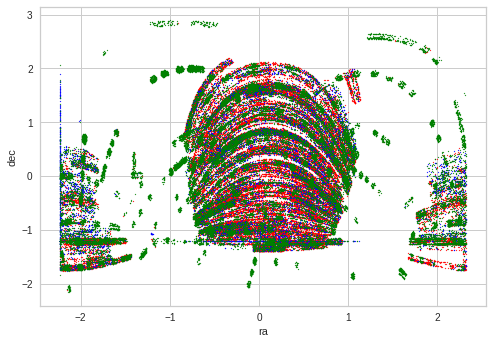

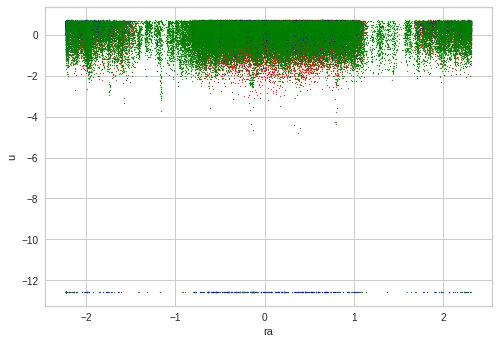

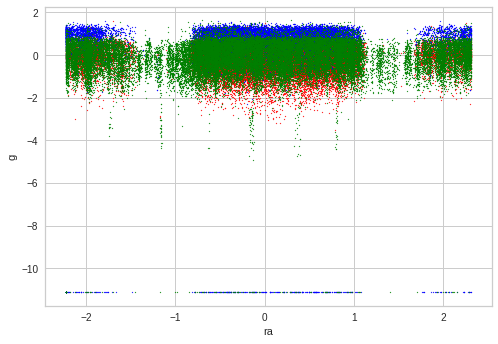

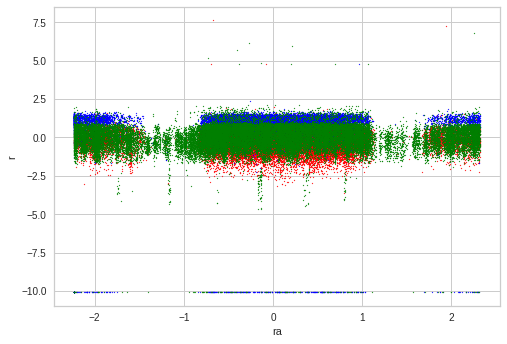

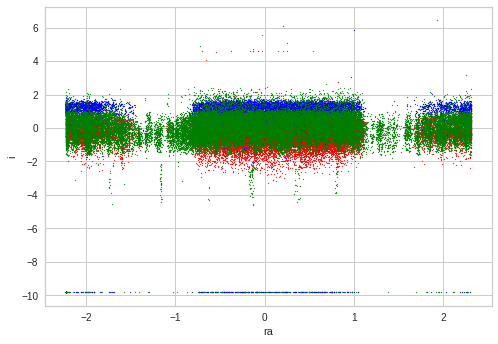

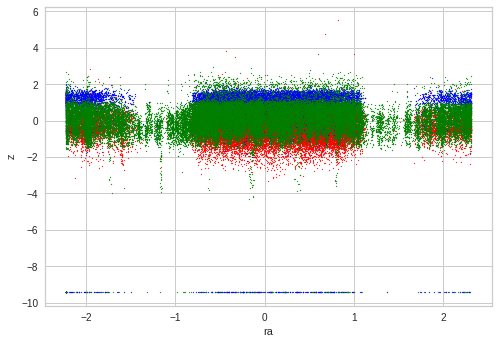

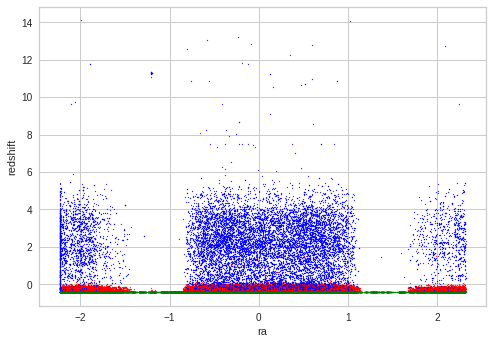

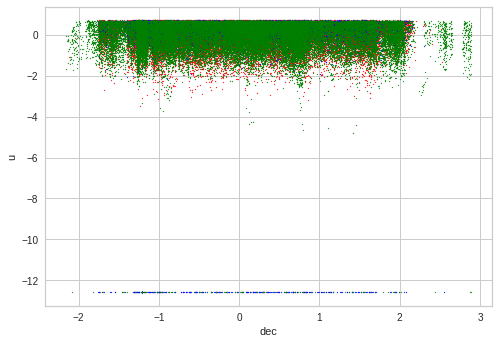

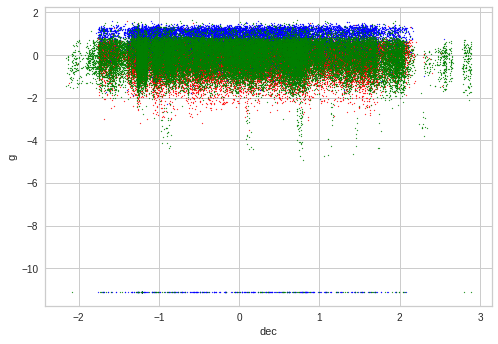

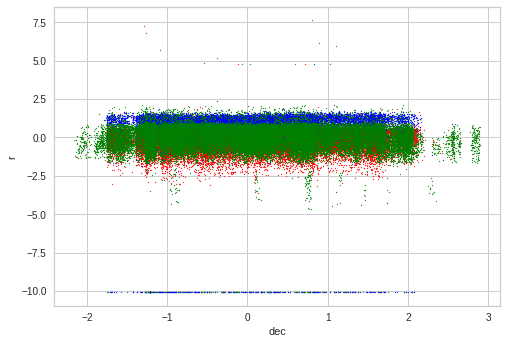

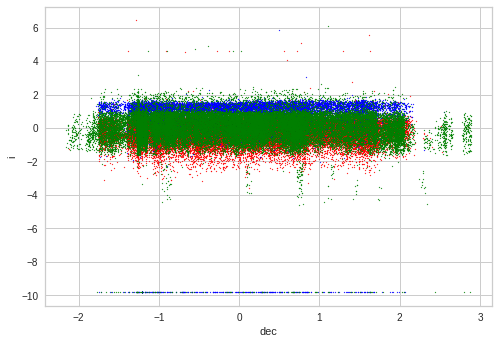

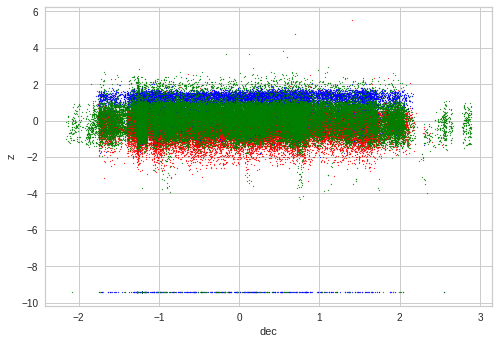

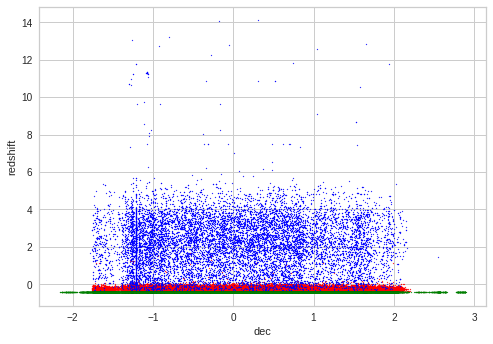

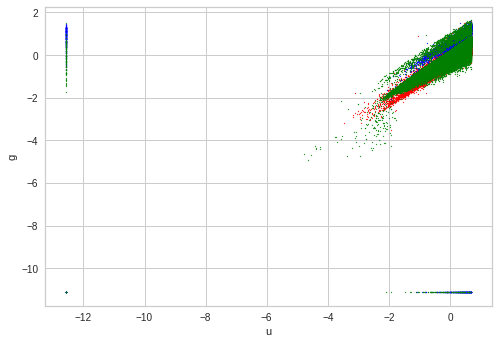

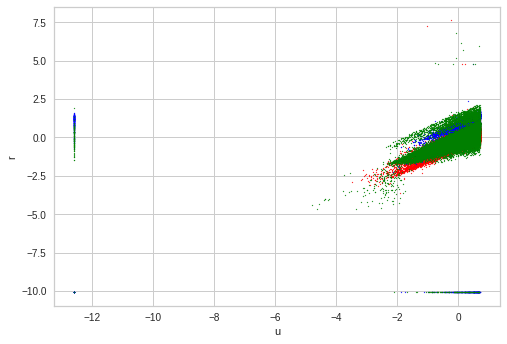

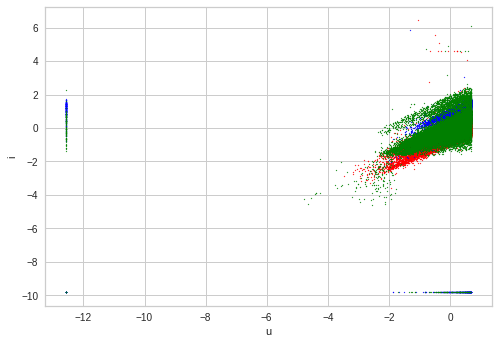

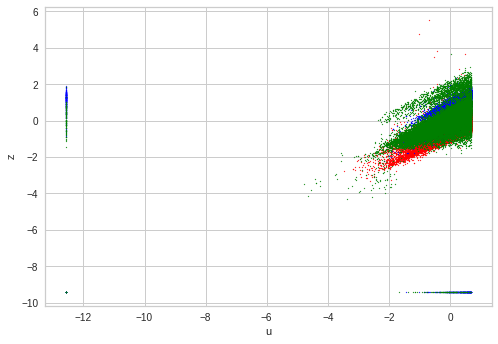

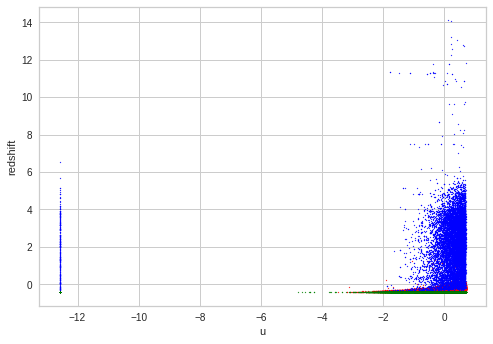

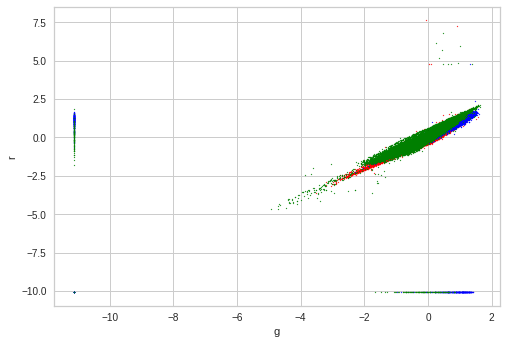

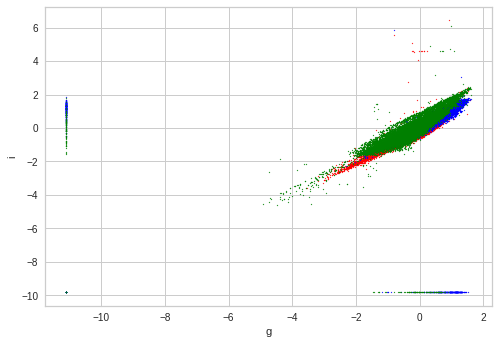

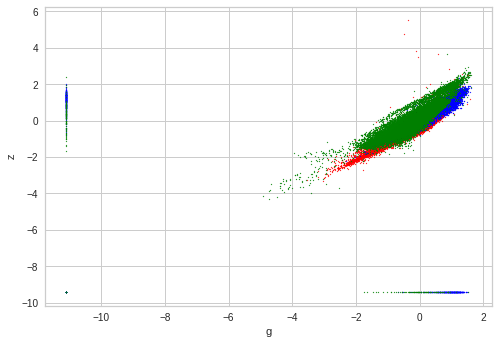

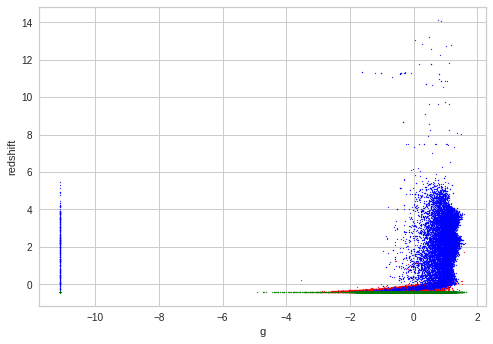

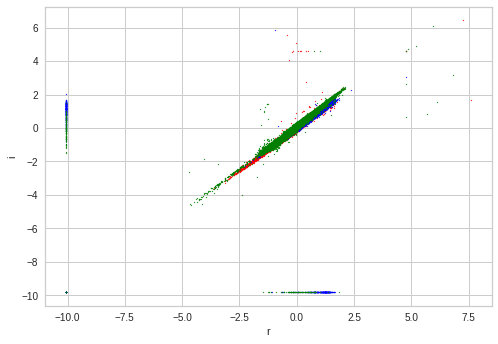

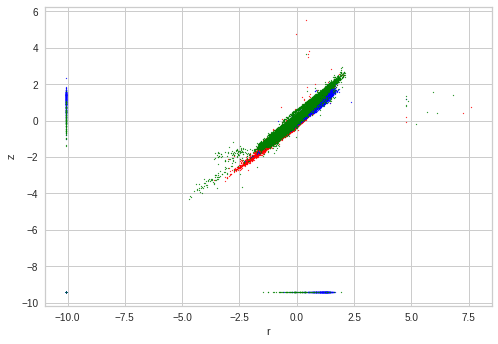

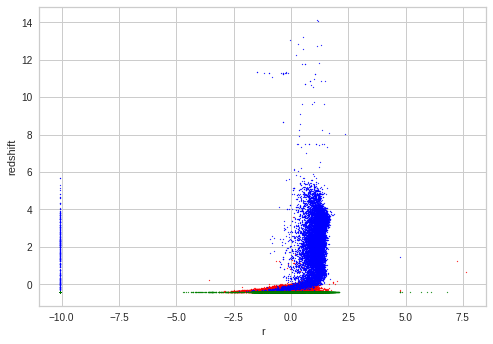

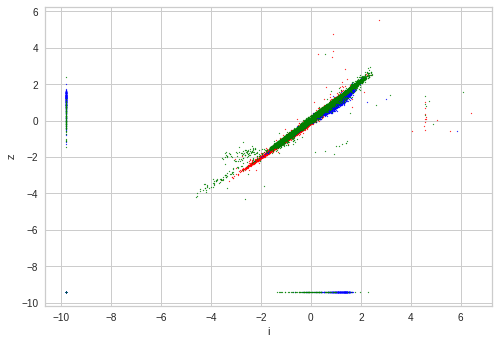

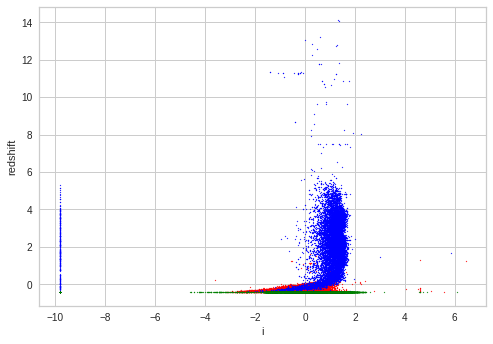

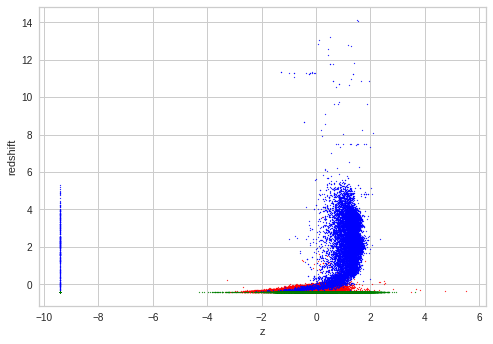

In [181]:
colors = ["red", "blue", "green"]
for x in range(len(headers)):
    for y in range(x+1, len(headers)):
        for i in range(np.unique(cleanLabels).shape[0]):
            ind = np.where(cleanLabels == i)
            label = str(labEncoder.inverse_transform([i]))
            plt.scatter(cleanData[ind, x], cleanData[ind, y], s=1, color=colors[i], alpha=0.8)
        plt.ylabel(headers[y])
        plt.xlabel(headers[x])
        # plt.legend(class_name)
        plt.show()

- As can be observed from the scatterplot diagram, using the selected columns we can easily classify between Star, Galaxy and QSO. 

- Alpha and delta, despite their low correlation with those identifying the filters photometric filters, were not removed because scatter plot analysis shows that they could have a nonnegligible impact particularly in the classification of stars versus galaxies and quasars.

In [182]:
# Correlation matrix after removing outliers and unused columns
df_CleanData = pd.DataFrame(cleanData)
corr = df_CleanData.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7
0,1.000000,0.078016,0.021151,0.014413,0.012139,0.013489,0.006937,-0.022429
1,0.078016,1.000000,-0.013146,-0.008178,-0.000229,0.001417,0.005973,0.001593
2,0.021151,-0.013146,1.000000,0.316284,0.274483,0.249593,0.232804,0.039121
3,0.014413,-0.008178,0.316284,1.000000,0.397032,0.408394,0.402280,0.223628
4,0.012139,-0.000229,0.274483,0.397032,1.000000,0.480401,0.470032,0.278088
5,0.013489,0.001417,0.249593,0.408394,0.480401,1.000000,0.506746,0.299052
6,0.006937,0.005973,0.232804,0.402280,0.470032,0.506746,1.000000,0.291558
7,-0.022429,0.001593,0.039121,0.223628,0.278088,0.299052,0.291558,1.000000


## Modelling

In [183]:
#Splitting the data into a training and test set. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_CleanData, cleanLabels, test_size = 0.2)

# Convert to pandas dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


In [184]:
classes = ['GALAXY','STAR','QSO']

In [185]:
def save_model(model_name,clf):
  """
  This function save the model to a binary pickle file
  """
  pkl_Filename = "/content/"+model_name+"_Model.pkl"  
  with open(pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

In [186]:
def classifier(model_name):
  """
  This function runs the classifier and save the model to a binary pickle file
  return: model
  """
  np.random.seed(42)
  
  if model_name == "LogisticRegression":
    clf = LogisticRegression().fit(X_train, y_train)
  elif model_name == "KNeighborsClassifier":
    clf = KNeighborsClassifier().fit(X_train, y_train)

  score = clf.score(X_train, y_train)
  print("Model: ",model_name)
  print('Accuracy of '+model_name+' on train set: %.3f' % (score*100))
  save_model(model_name,clf)
  return clf

def get_metrics(preds, y_true):
  """
  This function calculates the F1 Score , F1 Mirco and F1 MAcro score. As this is a class imbalance problem we have to look at multiple metrics instead of one.
  """
  acc_score = accuracy_score(y_true, preds)
  f1_w = f1_score(y_true, preds, average = "weighted")
  f1_macro = f1_score(y_true, preds, average = "macro")
  f1_micro = f1_score(y_true, preds, average = "micro")
  print("Test ACC: {}".format(acc_score))
  print("F1 WEIGHTED: {}".format(f1_w))
  print("F1 MACRO: {}".format(f1_macro))
  print("F1 MICRO: {}".format(f1_micro))


def confusion_metrix(model):
  """
  This function computes confusion matrix
  Return: confusion matrix object
  """
  cm = ConfusionMatrix(model, classes=classes, cmap='GnBu')
  cm.fit(X_train,y_train)
  cm.score(X_test, y_test)
  cm.show()
  return cm


def visualize_ROC_curve(cm,classes):
  """
  This function plots ROC curve along with Area under the curve (AUC)
  """
  visualizer = ROCAUC(cm, classes=classes)
  set_palette('bold')
  visualizer.fit(X_train,y_train)        # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)        # Evaluate the model on the test data
  visualizer.show()

### Models
- > 1: Logistic Regression


In [187]:
print("On Train Set")
model_name = "LogisticRegression"
lr_clf = classifier(model_name)

print("-------------------------------------------")

# make prediction on test set
print("On Test Set")
pred = lr_clf.predict(X_test)
get_metrics(pred, y_test)

On Train Set
Model:  LogisticRegression
Accuracy of LogisticRegression on train set: 97.125
-------------------------------------------
On Test Set
Test ACC: 0.969743987587277
F1 WEIGHTED: 0.9694246176030544
F1 MACRO: 0.9616332149224173
F1 MICRO: 0.969743987587277


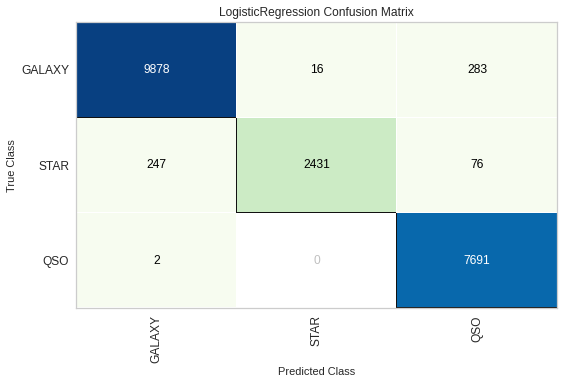

In [188]:
#  Confusion Martix for the model 
lr_cm = confusion_metrix(lr_clf)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



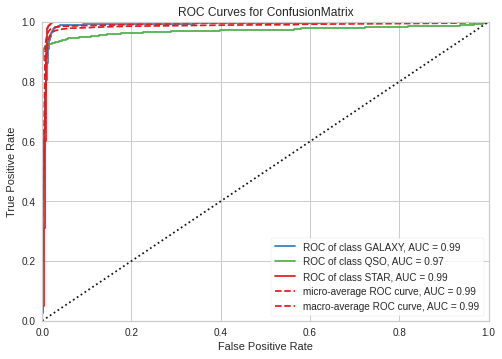

In [189]:
# ROC Curve for the model
visualize_ROC_curve(lr_cm, classes)

In [190]:
print("On Train Set")
model_name = "KNeighborsClassifier"
knn_clf = classifier(model_name)

print("-------------------------------------------")

# make prediction on test set
print("On Test Set")
pred = knn_clf.predict(X_test)
get_metrics(pred, y_test)

On Train Set
Model:  KNeighborsClassifier
Accuracy of KNeighborsClassifier on train set: 95.475
-------------------------------------------
On Test Set
Test ACC: 0.9331361520558572
F1 WEIGHTED: 0.9332515145965149
F1 MACRO: 0.9365091312986631
F1 MICRO: 0.9331361520558572


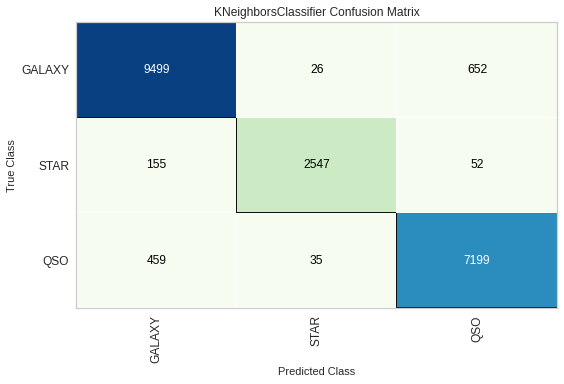

In [191]:
#  Confusion Martix for the model 
knn_cm = confusion_metrix(knn_clf)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



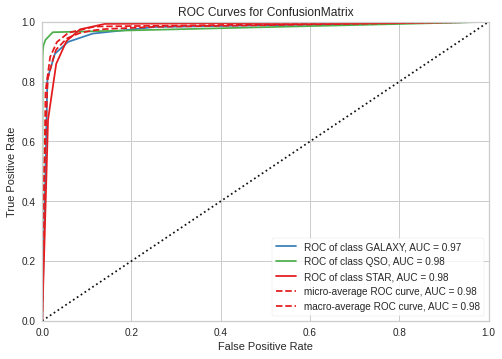

In [192]:
# ROC Curve for the model
visualize_ROC_curve(knn_cm, classes)